In [1]:
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from torch.distributions.categorical import Categorical
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR
from torch.utils.data import DataLoader

import numpy as np
from numpy.random import choice, permutation, randint
import pickle as pkl

from tqdm.notebook import tqdm
import networkx as nx

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit import RDLogger   


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

from IPython.display import SVG

from collections import defaultdict
import multiprocessing as mp
from statistics import stdev, mean
from pathlib import Path
import pickle as pkl
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from collections import namedtuple

In [2]:
NUM_CPU = 3
SEED = 3287450

In [3]:
torch.manual_seed(SEED)
torch.cuda.empty_cache()
sns.set(style='white', context='notebook', rc={'figure.figsize':(9,7)})
np.set_printoptions(threshold=sys.maxsize)
RDLogger.DisableLog('rdApp.*') 

In [4]:
def save(thing, path):
    with open(path, 'wb') as fp:
        pkl.dump(thing, fp)
    print(f'saved [{type(thing)}] to {path}')

In [5]:
def load(path):
    with open(path, 'rb') as fp:
        thing = pkl.load(fp)
    return thing

# Data 

In [6]:
!ls ./data/lipinski

active_lipinski.smi		 druglike-qed-data.pkl
active-qed-data.pkl		 gcpn_smiles.500.smi
all_lipinski.smi		 lstm_smiles.500.smi
druglike_lipinski_100k.smi	 qed_df_full.pickle
druglike_lipinski_10k.smi	 qed_df.pickle
druglike_lipinski_1k.smi	 qed_df_small.activity.pickle
druglike_lipinski_50k.test.smi	 results
druglike_lipinski_50k.train.smi  very_active_lipinski.smi
druglike_lipinski.smi		 very-active-qed-data.pkl


In [7]:
DATA_PATH = Path('./data/lipinski/')

In [8]:
def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: 
        return None
    Chem.Kekulize(mol)
    return mol

In [9]:
def process_smiles_file(path, test_split=0.15):
    all_smiles = []
    with open(path) as fp:
        for line in tqdm(fp.readlines()):
            all_smiles += [line[:-1]]
    size = len(all_smiles)
    split = int(size * test_split)
    return all_smiles[split:] ,  all_smiles[:split]

In [10]:
P1_SMILES = process_smiles_file(DATA_PATH / 'druglike_lipinski_1k.smi')

In [11]:
ALL_SMILES = P1_SMILES[0] + P1_SMILES[1] 
len(ALL_SMILES)

1000

In [12]:
tmol = Chem.MolFromSmiles(ALL_SMILES[0]) # test mol

## Helper Functions

In [13]:
def bfs_seq(G, start_id):
    dictionary = dict(nx.bfs_successors(G, start_id))
    start = [start_id]
    output = [start_id]
    while len(start) > 0:
        next = []
        while len(start) > 0:
            current = start.pop(0)
            neighbor = dictionary.get(current)
            if neighbor is not None:
                #### a wrong example, should not permute here!
                # shuffle(neighbor)
                next = next + neighbor
        output = output + next
        start = next
    return np.array(output)

In [14]:
order_adj = lambda adj, pi: adj[np.ix_(pi, pi)]

In [15]:
def get_bfs_ordering(adj):    
    adj_matrix = np.asmatrix(adj)
    G = nx.from_numpy_matrix(adj_matrix)
    
    start_node = randint(adj.shape[0])
    bfs_pi = np.array(bfs_seq(G, start_node))

    return bfs_pi

In [16]:
dim = lambda m: len(m.shape)

## Datatype Transforms

In [17]:
ELEM_LIST = set()
for m in map(Chem.MolFromSmiles, ALL_SMILES):
    if m is None: continue

    for atom in m.GetAtoms():
        ELEM_LIST.add(atom.GetSymbol())
        
ELEM_LIST = list(ELEM_LIST)
ELEM_LIST

['F', 'Br', 'S', 'C', 'I', 'P', 'Cl', 'N', 'O']

In [ ]:
# ELEM_CMAP = {
#     'F', 
#     'Br', 
#     'S',
#     'C', 
#     'I',
#     'P', 
#     'Cl', 
#     'N', 
#     'O'
# }

In [119]:
BOND_TYPES = [Chem.rdchem.BondType.SINGLE, 
              Chem.rdchem.BondType.DOUBLE, 
              Chem.rdchem.BondType.TRIPLE, 
              Chem.rdchem.BondType.AROMATIC]
BOND_CMAP = {
    Chem.rdchem.BondType.SINGLE:  '#28536B',
    Chem.rdchem.BondType.DOUBLE:  '#C2948A',
    Chem.rdchem.BondType.TRIPLE:  '#BBB193',
    Chem.rdchem.BondType.AROMATIC:'#511730',
}

In [20]:
ATOM_FDIM = len(ELEM_LIST) + 6 + 5 + 1
BOND_FDIM = len(BOND_TYPES)

### Atom and Bond Feature Vectors

In [115]:
def onek_encoding(x, allowable_set):
    return list(map(lambda s: x == s, allowable_set))

def onek_decoding(x, allowable_set):
    topi = np.argmax(x)
    return allowable_set[topi]
    

def atom_to_vec(atom):
    return torch.Tensor(onek_encoding(atom.GetSymbol(), ELEM_LIST) 
            + onek_encoding(atom.GetDegree(), [0,1,2,3,4,5]) 
            + onek_encoding(atom.GetFormalCharge(), [-1, -2, 1, 2, 0])
            + [atom.GetIsAromatic()])

def bond_to_vec(bond):
    bt = bond.GetBondType()
    return torch.Tensor(onek_encoding(bt, BOND_TYPES))
                         #+[bond.IsInRing()])

def vec_to_atom(vec):
    atom_type = onek_decoding(vec[:len(ELEM_LIST)], ELEM_LIST)
    atom_degree = onek_decoding(vec[len(ELEM_LIST):len(ELEM_LIST) + 6],  [0,1,2,3,4,5])
    atom_charge = onek_decoding(vec[len(ELEM_LIST)+6:len(ELEM_LIST)+6+5], [-1, -2, 1, 2, 0])
    atom_is_aromatic = int(vec[-1])
    
    a = Chem.Atom(atom_type)
    a.SetFormalCharge(atom_charge)
    a.SetIsAromatic(atom_is_aromatic)
    
    return a

def vec_to_bond(vec):
    return onek_decoding(vec, BOND_TYPES)
    

In [22]:
def feature_m_to_atoms(F):
    n = F.shape[0]
    atom_map = {}
    for i in range(n):
        atom = vec_to_atom(F[i])
        atom_map[i] = atom
    return atom_map

In [75]:
def make_featured_graph(E, F):
        
    G = nx.Graph()
    
    for (start_idx, end_idx, bond_type) in cond_adj_to_bonds(E):
            G.add_edge(start_idx, end_idx, btype=bond_type, colour=BOND_CMAP[bond_type])
            
    atom_map = feature_m_to_atoms(F)
    G.add_nodes_from(np.arange(len(atom_map)))
    
    for atom_idx, atom in atom_map.items():
        G.nodes[atom_idx]['atom_type'] = atom.GetSymbol()
    
    return G

In [109]:
def draw_featured_graph(G):
    
    pos = nx.kamada_kawai_layout(G)

    atom_labels = {i : datum['atom_type'] for (i, datum) in G.nodes.data()}
    
    edge_colours = [datum['colour'] for (_,_,datum) in G.edges.data()]

    nx.draw_networkx_nodes(G, pos, node_size=30)
    nx.draw_networkx_labels(G, pos, labels=atom_labels, font_size=14)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=5, edge_color=edge_colours)

### Mol and Tensor

In [159]:
def get_ltri(M, k=-1):
    """
    get_ltri(M):
        - pick up lower triangle from matrix with dim(M) = 3
    """
    if len(M.shape) == 2:
        return np.tril(M, k=k)
    
    triM = np.zeros(M.shape)
    for f_dim in range(M.shape[-1]):
        triM[..., f_dim] = np.tril(M[...,f_dim],k=k)
    return triM

In [27]:
def cond_adj_to_bonds(E):
    E = get_ltri(E)
    
    row_idxs, col_idxs = np.nonzero(E.sum(axis=-1))
    bonds = []
    
    for row, col in zip(row_idxs, col_idxs):
        bond_vec = E[row, col]
        
        bond_type = vec_to_bond(bond_vec)
        bonds += [(row, col, bond_type)]
                   
    return bonds

In [28]:
def mol_to_tensors(mol):
    """
    mol_to_tensor(mol):
        - make edge conditioned adjacency matrix --> E
        - make atom feature matrix --> F
    """
    n = mol.GetNumAtoms()
    E = np.zeros((n, n, BOND_FDIM))
    
    for bond in mol.GetBonds():
        s_idx = bond.GetBeginAtomIdx()
        e_idx = bond.GetEndAtomIdx()
        
        bond_enc = bond_to_vec(bond)
        E[s_idx, e_idx] = bond_enc
        E[e_idx, s_idx] = bond_enc # undirected graph
    
    F = np.zeros((n, ATOM_FDIM))
    for atom in mol.GetAtoms(): # order tho
        atom_idx = atom.GetIdx()
        atom_enc = atom_to_vec(atom)
        F[atom_idx, :] = atom_enc
        
    return E, F
    
def tensors_to_mol(E, F):
    global M
    
    n = E.shape[0]
    assert F.shape[0] == n
    
    mol = Chem.RWMol()
    node_to_idx = dict()
    
    for n_idx in range(n):
        atom_enc = F[n_idx, :]
        atom = vec_to_atom(atom_enc)
        atom_idx = mol.AddAtom(atom)
        node_to_idx[n_idx] = atom_idx
        
    for (row, col, bond_type) in cond_adj_to_bonds(E):
        
        start_atom = node_to_idx[row]
        end_atom = node_to_idx[col]
        
        mol.AddBond(start_atom, end_atom, bond_type)
        
    Chem.SanitizeMol(mol)
    return mol
    

### Mol and Graph

In [29]:
def mol_to_adj(mol):
    return nx.to_numpy_array(mol_to_nx(mol))

def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   formal_charge=atom.GetFormalCharge(),
                   chiral_tag=atom.GetChiralTag(),
                   hybridization=atom.GetHybridization(),
                   num_explicit_hs=atom.GetNumExplicitHs(),
                   is_aromatic=atom.GetIsAromatic())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
    return G


def nx_to_mol(G):
    mol = Chem.RWMol()
    atomic_nums = nx.get_node_attributes(G, 'atomic_num')
    chiral_tags = nx.get_node_attributes(G, 'chiral_tag')
    formal_charges = nx.get_node_attributes(G, 'formal_charge')
    node_is_aromatics = nx.get_node_attributes(G, 'is_aromatic')
    node_hybridizations = nx.get_node_attributes(G, 'hybridization')
    num_explicit_hss = nx.get_node_attributes(G, 'num_explicit_hs')
    node_to_idx = {}
    for node in G.nodes():
        a = Chem.Atom(atomic_nums[node])
        a.SetChiralTag(chiral_tags[node])
        a.SetFormalCharge(formal_charges[node])
        a.SetIsAromatic(node_is_aromatics[node])
        a.SetHybridization(node_hybridizations[node])
        a.SetNumExplicitHs(num_explicit_hss[node])
        idx = mol.AddAtom(a)
        node_to_idx[node] = idx

    bond_types = nx.get_edge_attributes(G, 'bond_type')
    for edge in G.edges():
        first, second = edge
        ifirst = node_to_idx[first]
        isecond = node_to_idx[second]
        bond_type = bond_types[first, second]
        mol.AddBond(ifirst, isecond, bond_type)

    Chem.SanitizeMol(mol)
    return mol

### Graph, MolTensors and SequenceTensors

In [160]:
def adj_to_seq(adj):
    """
    adj_to_seq_tensor(adj, M):
         - requires M which is emprically calculated max prev node
         - adj is a adjacency matrix dim(A) = (n-1, n-1) 
           also adj only has values in the lower triangle
    returns: sequence tensor S dim(S) = (n, M) 
    """
    global M

    n = adj.shape[0]
    f_dim = adj.shape[-1]
    
    adj = get_ltri(adj)
    adj = adj[1:, :n-1]
    n -= 1
    
    if dim(adj) == 3:
        S = np.zeros((n, M, f_dim))
    else:
        S = np.zeros((n, M))
    
    for i in range(n):
        input_start = max(0, i - M + 1)
        input_end = i + 1
        
        output_start = M + input_start - input_end
        output_end = M
        
        S[i, output_start:output_end] = adj[i, input_start:input_end]
        S[i, :] = np.flip(S[i, :], axis=0)
        
    return S


def seq_to_adj(S):
    """

    """
    global M
    
    n = S.shape[0]
    f_dim = S.shape[-1]
    
    if len(S.shape) == 3:
        adj = np.zeros((n, n, f_dim))
    else:
        adj = np.zeros((n, n))

    for i in range(n):
        
        input_start = max(0, i - M + 1)
        input_end = i + 1
        
        output_start = M + max(0, i - M + 1) - (i + 1)
        output_end = M
        temp = np.flip(S[i],0)
        
        adj[i, input_start:input_end] = temp[output_start:output_end] # reverse order
        
    if len(S.shape) == 3:
        adj_full = np.zeros((n+1, n+1, f_dim))
    else:
        adj_full = np.zeros((n+1, n+1))
        
    n = adj_full.shape[0]
    adj_full[1:n, 0:n-1] = get_ltri(adj, k=0)
    
    if len(S.shape) == 3:
        adj_full = adj_full + np.transpose(adj_full, (1, 0, 2))
    else:
        adj_full = adj_full + adj_full.T
        
    return adj_full

In [142]:
E.T.shape

(4, 21, 21)

In [143]:
E + E.T

ValueError: operands could not be broadcast together with shapes (21,21,4) (4,21,21) 

### Full Transform Pipeline

In [31]:
def forward_transform(mol):
    E, F = mol_to_tensors(mol)
    
    bfs_order = get_bfs_ordering(E.sum(axis=-1))
    E = order_adj(E, bfs_order)
    F = F[bfs_order]
    
    S = adj_to_seq(E)
    return S, F

def backward_transform(S, F):
    E = seq_to_adj(S)
    return tensors_to_mol(E, F)
    

## Calculating Max Prev Node

In [32]:
def encode_adj_flexible(adj):
    # get rid of duplicate info
    adj = np.tril(adj, k=-1)
    n = adj.shape[0]
    adj = adj[1:n, 0:n-1]

    adj_output = []
    input_start = 0
    for i in range(adj.shape[0]):
        input_end = i + 1
        adj_slice = adj[i, input_start:input_end]
        adj_output.append(adj_slice)
        non_zero = np.nonzero(adj_slice)[0]
        input_start = input_end-len(adj_slice)+np.amin(non_zero)

    return adj_output

In [77]:
def compute_max_prev_nodes(smiles):
    max_ms = []
    for s in tqdm(smiles):
        mol = get_mol(s)
        
        if mol is None: 
            continue
            
        G = mol_to_nx(mol)
        adj = nx.to_numpy_matrix(G)
        #
#         rand_pi = permutation(adj.shape[0])
#         adj = order_adj(adj, rand_pi)

        adj_matrix = np.asmatrix(adj)
        G = nx.from_numpy_matrix(adj_matrix)

        start_node = randint(adj.shape[0])
        bfs_pi = np.array(bfs_seq(G, start_node))
        #
        adj = order_adj(adj, bfs_pi)
        
        adj_slices = encode_adj_flexible(adj.copy())
        
        max_m = max(map(len, adj_slices))
        max_ms += [max_m]
        
    return max(max_ms)

In [78]:
M = compute_max_prev_nodes(ALL_SMILES[:1])
M

7

### Testing Transforms

[rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 rdkit.Chem.rdchem.BondType.DOUBLE,
 rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 rdkit.Chem.rdchem.BondType.AROMATIC]

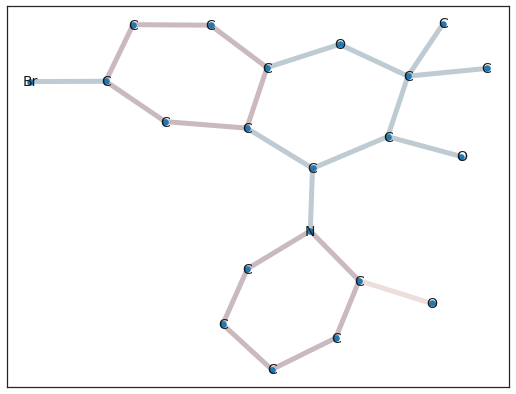

In [120]:
truegraph = mol_to_nx(tmol)
tE, tF = mol_to_tensors(tmol)

tG = make_featured_graph(tE, tF)
draw_featured_graph(tG)

In [122]:
# bfs order test PASS

In [126]:
E, F = mol_to_tensors(tmol)

In [127]:
bfs_order = get_bfs_ordering(E.sum(axis=-1))
E = order_adj(E, bfs_order)
F = F[bfs_order]

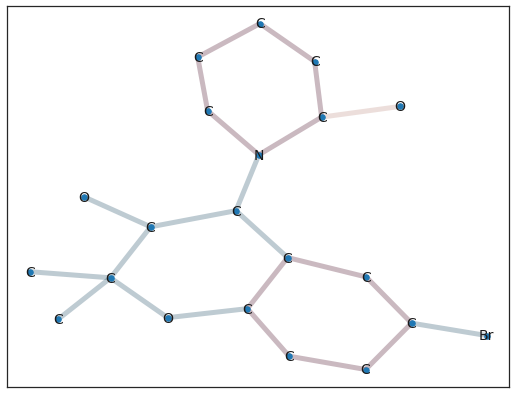

In [128]:
bfsG = make_featured_graph(E, F)
draw_featured_graph(bfsG)

In [161]:
seqE = seq_to_adj(adj_to_seq(E))

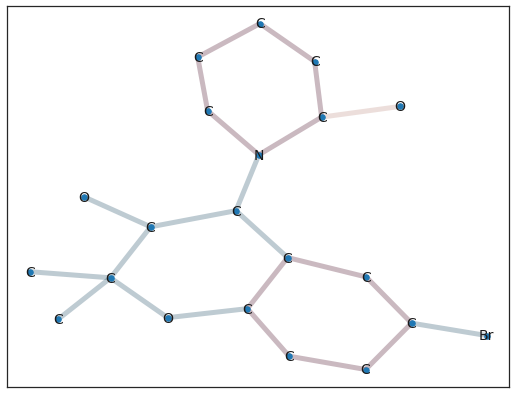

In [162]:
seqG = make_featured_graph(seqE, F)
draw_featured_graph(seqG)

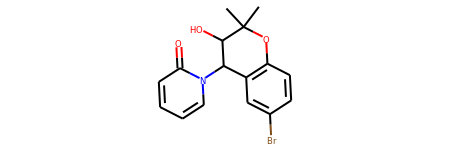

In [174]:
backward_transform(adj_to_seq(E), F)

In [177]:
adj_to_seq(E).shape, F.shape

((20, 7, 4), (21, 21))

## GraphDataset

In [ ]:
class GraphDataset(torch.utils.data.Dataset):
    
    def __init__(self, smiles):
        self.all_smiles = smiles
        self.size = len(smiles)

    def __len__(self):
        return self.size
    
    def __getitem__(self, i):
        """
        __getitem__(self, i):
            - return 
        """
        x_i, x_n = encode(self.all_smiles[i])
        
        y_i = x_i[1:].copy()
        x_i = x_i[:-1].copy()
        
        return x_i, y_i, x_n
    

## TransferLearning Phases

In [ ]:
def make_phase(data, pid, lr, interval, ):
    Phase = namedtuple('Phase', ['pid', 'traindata', 'testdata', 'lr', 'test_interval'])
    phase = Phase(traindata=SMILESDataset(data[0]),
                  testdata=SMILESDataset(data[1]),
                  lr=lr,
                  pid=pid, # phase id
                  test_interval=interval)
    
    return phase
    

In [ ]:
LR_BASE = 3e-3
P1 = make_phase(P1_SMILES, 1, 3e-3/2, 500)
P2 = make_phase(P2_SMILES, 2,3e-4, 100)
P3 = make_phase(P3_SMILES, 3, 3e-4/2, 50)

# Model

In [ ]:
# plain LSTM model
class GeneratorLSTM(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size, embedding_size, bidirectional):
        super().__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(input_size=embedding_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=0.15,
                            bidirectional=bidirectional)
        
        self.input_module = nn.Sequential(nn.Linear(input_size, 256),
                                         nn.ReLU(),
                                         nn.Dropout(0.10),
                                         nn.Linear(256, 512),
                                         nn.ReLU(),
                                         nn.Dropout(0.10),
                                         nn.Linear(512, embedding_size),
                                         nn.ReLU())
        lstm_output_shape = hidden_size if not bidirectional else hidden_size * 2
        self.output_module = nn.Sequential(nn.Linear(lstm_output_shape , 256),
                                           nn.Dropout(0.10),
                                           nn.ReLU(),
                                           nn.Linear(256, output_size))

        self.hidden = None 

    def init_hidden(self, batch_size, cuda=True):
        if self.bidirectional:
            ht = Variable(torch.zeros(self.num_layers*2, batch_size, self.hidden_size))
            ct = Variable(torch.zeros(self.num_layers*2, batch_size, self.hidden_size))
        else:
            ht = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
            ct = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))
            

        if cuda:
            return ht.cuda(), ct.cuda()
        else:
            return ht, ct
            


    def forward(self, input_raw, pack=False, input_lens=None):
        """
        forward(self, input_raw, state):
             - input_raw = (bs, x_{i,t})
             - state = (ht, ct)
        """
        input_ = self.input_module(input_raw)
        
        if pack:
            input_ = pack_padded_sequence(input_, input_lens, batch_first=True)
            
        input_, self.hidden = self.lstm(input_, self.hidden)
        
        if pack: 
            input_ = pad_packed_sequence(input_, batch_first=True)[0]

            
        input_ = self.output_module(input_)
        return input_

In [ ]:
model = GeneratorLSTM(input_size = NUM_SYM, 
                      output_size = NUM_SYM, 
                      num_layers = 3, 
                      hidden_size = 512, 
                      embedding_size = 512,
                      bidirectional=False)

In [ ]:
model.cuda()

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'model has [{count_parameters(model):,}] trainable params')

## Train

In [ ]:
def train_one_epoch(model, model_optim, lr_sched,
                    train_dataloader, test_dataloader, 
                    test_interval, save_path, epoch):
    
    criterion = nn.NLLLoss()
    loss_history = []
    total = len(train_dataloader)
    
    test_loss_history = defaultdict(list)
    new_smiles = defaultdict(list)
    
    
    for batch_idx, batch in tqdm(enumerate(train_dataloader), total=total):
        
        if batch_idx % test_interval == 0:
            new_smiles[batch_idx] = generate(model,)
            
            smiles_valid_batch = generate(model, test_samples=100, sample_f=softmax_temp_sample, v=False)
            validity = count_valid(smiles_valid_batch)
            
            test_loss_history[batch_idx] = test(model, test_dataloader)
            # we can test later
            
            print(f'[batch num: {batch_idx}] sampled; [{validity:.3f}%] valid smiles sampled')
            
            if batch_idx == 0:
                print_loss = 'nan'
            else:
                print_loss = f'{loss.data.item():.4f}'

            
            path = save_path / Path(f'{epoch}-epoch-{batch_idx}-batch-{print_loss}-loss')
            path.mkdir(exist_ok=True)
            
            torch.save(model.state_dict(), str(path / 'model_dict.torch'))
            save(new_smiles[batch_idx], str(path / 'generated_smiles.list' ))
            save(test_loss_history[batch_idx] , str(path / 'test_loss.item' ))
        
        model.train()
        model.zero_grad()
    
        x_batch, y_batch, batch_lens = batch
        
        batch_size = x_batch.size(0)
        max_len = int(max(batch_lens).item())
        
        x_batch = x_batch[:, 0:max_len, :]
        y_batch = y_batch[:, 0:max_len, :]

        # sort input
        batch_len_sorted, sort_index = torch.sort(batch_lens, 0, descending=True)
        batch_len_sorted = batch_len_sorted.numpy().tolist()
        
        x_batch = torch.index_select(x_batch, 0, sort_index)
        y_batch = torch.index_select(y_batch, 0, sort_index)

        x_batch = Variable(x_batch.float()).cuda()
        y_batch = Variable(y_batch.float()).cuda()

        # init state
        model.hidden = model.init_hidden(batch_size=x_batch.size(0))
        try:
            y_pred = model(x_batch, pack=True, input_lens=batch_len_sorted)
        except Exception as e:
            print(f'[ERROR] got exception {e}')
            print(f'[ERROR] skipping batch...')
            continue
        
        y_pred = F.log_softmax(y_pred.view(-1, NUM_SYM), dim=-1)
        _, y_batch = y_batch.topk(1, dim=-1)
        y_batch = y_batch.view(-1)
        loss = criterion(y_pred, y_batch)
        
        loss.backward()
        model_optim.step()
        lr_sched.step()

        
        if batch_idx % 10 == 0 :
            print(f'[batch num: {batch_idx}] loss: {loss.data.item():.4f}')
            
    path = save_path / Path(f'{epoch}-epoch-END-batch')
    path.mkdir(exist_ok=True)

    torch.save(model.state_dict(), str(path / 'model_dict.torch'))

                
    return loss_history, test_loss_history, new_smiles

In [ ]:
def make_run_id():
    return  np.random.choice(['cheetah', 'jaguar', 'wombat', 'cobra', 
                               'croc', 'panda', 'dragon', 'seal', 'spider', 'lizard',
                               'gorilla', 'koala', 'blackbear', 'grizzly', 'zebra',
                               'hippo'])

In [ ]:
make_run_id()

In [ ]:
def transfer_learning(model, phases, epochs, batch_size=32, run_id = None):
    """
    transfer_learning(model, phases):
        - model: pytorch model
        - phases: [Datasets] for datapaths
    """
    history = defaultdict(dict)
    
    run_id = run_id if run_id is not None else make_run_id()
    
    results_dir = DATA_PATH / 'results' / f'{run_id}-run'
    results_dir.mkdir(exist_ok=False)
    save(SYM_TO_ID, results_dir / 'SYM_TO_ID')
    save(ID_TO_SYM, results_dir / 'ID_TO_SYM')

    print(f'[TRANSFER_LEARNER] saving all progress to [{results_dir}]')
    
    for idx, phase in enumerate(phases):
        print(f'[TRANSFER_LEARNER] STARTING PHASE [{phase.pid}]')
        
        dataloader = DataLoader(phase.traindata, 
                                batch_size=batch_size, 
                                num_workers=NUM_CPU, 
                                shuffle=True)
        
        testloader = DataLoader(phase.testdata, 
                                batch_size=1000, 
                                num_workers=NUM_CPU, 
                                shuffle=True)
        
        model_optim = optim.Adam(list(model.parameters()), lr=phase.lr)
        lr_sched = CosineAnnealingLR(model_optim, 500)
        
        phase_dir = results_dir / f'phase-{phase.pid}'
        phase_dir.mkdir(exist_ok=True)
        
        for epoch_idx in range(epochs[idx]):
            print(f'[TRANSFER_LEARNER] PHASE [{phase.pid}] EPOCH [{epoch_idx}]')
            history[phase.pid][epoch_idx] = train_one_epoch(model, model_optim, lr_sched,
                                                   dataloader, testloader,
                                                   phase.test_interval, phase_dir, 
                                                   epoch_idx)
            
    return history
            
            
            
    

## Testing and Generation

In [ ]:
def softmax_temp_sample(y_t, temperature = 1.0):
    prediction_vector = F.softmax(y_t / temperature, dim=-1)
    x_index_t = torch.multinomial(prediction_vector, 1)[:, 0]
    return x_index_t

In [ ]:
def topk_sample(y_t):
    _, pred_idx =  y_t.topk(1, dim=-1)
    return pred_idx

In [ ]:
def generate(model, test_samples=5, sample_f=softmax_temp_sample, v=True):
    with torch.no_grad():
        model.eval()

        x = torch.zeros(test_samples, MAX_SYM, NUM_SYM).cuda()

        x[:, 0, SYM_TO_ID[GO_TOKEN]] = 1
        
        for i in range(MAX_SYM-1):
            model.hidden = model.init_hidden(batch_size=test_samples)
            
            pred = model(x, pack=True, input_lens=np.ones(test_samples)*(i+1))
            pred_idx = sample_f(pred[:,i,:])
            temp = torch.zeros(test_samples, MAX_SYM, NUM_SYM).cuda()
            for j in range(test_samples):
                temp[j, i+1, pred_idx[j]] = 1  
            x.add_(temp)

        if v: print('\n',10*'-' + 'GENERATED SMILES STRINGS' + 10*'-')
        smiles = []

        for j in range(test_samples):
            s = decode_valid(x[j].cpu().numpy())
            smiles += [s]

            if v: print(s)

        return smiles
        
    

In [ ]:
def test(model, testloader):
    with torch.no_grad():

        model.eval()

        criterion = nn.NLLLoss()
        total_loss = 0

        for batch in tqdm(testloader,total=len(testloader)):

            x_batch, y_batch, batch_lens = batch

            batch_size = x_batch.size(0)
            max_len = int(max(batch_lens).item())

            x_batch = x_batch[:, 0:max_len, :]
            y_batch = y_batch[:, 0:max_len, :]

            # sort input
            batch_len_sorted, sort_index = torch.sort(batch_lens, 0, descending=True)
            batch_len_sorted = batch_len_sorted.numpy().tolist()

            x_batch = torch.index_select(x_batch, 0, sort_index)
            y_batch = torch.index_select(y_batch, 0, sort_index)

            x_batch = Variable(x_batch.float()).cuda()
            y_batch = Variable(y_batch.float()).cuda()

            # init state
            model.hidden = model.init_hidden(batch_size=x_batch.size(0))

            y_pred = model(x_batch, pack=True, input_lens=batch_len_sorted)

            y_pred = y_pred.view(-1, NUM_SYM)
            _, y_batch = y_batch.topk(1, dim=-1)
            y_batch = y_batch.view(-1)

            total_loss += criterion(y_pred, y_batch)

        return total_loss.data.item() / len(testloader)
    

## Results

In [ ]:
history = transfer_learning(model, phases=[P1, P2, P3], epochs=[2, 2, 2])

In [ ]:
def plot_history(history, l=-1):
    if l < 0:
        l = len(history)
    fig = px.line(x=np.arange(l), y=history[:l], labels={'x':'batch number', 'y':'binary cross-entropy loss'})
    return fig

In [ ]:
history[2]

In [ ]:
!ls data/lipinski/results/panda-run/phase-0/0-epoch-3500-batch-0.4833-loss

In [ ]:
load('data/lipinski/results/panda-run/phase-0/0-epoch-3500-batch-0.4833-loss/generated_smiles.dict')

In [ ]:
load_path = './data/lipinski/results/panda-run/phase-0/0-epoch-3500-batch-0.4833-loss/model_dict.torch'

In [ ]:
model.load_state_dict(torch.load(load_path))

In [ ]:
newsmiles = generate(model, test_samples=500, sample_f=softmax_temp_sample)
validity = count_valid(newsmiles)
print(f'validity is at [{validity:.2f}%]')

In [ ]:
transfer_learning(model, [P2, P3], [2, 2] )